# Binned subsampling 

Intended to be the first of 4 examples in the paper, showing how the binomial can be used to subsample from a given distribution  

## todo

* expand timestepping with advection and longer timesteps

## done
* make plots
* make a timestepping function (without advection)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
from random import random
import matplotlib
from netCDF4 import Dataset
import matplotlib.cm as cm
import matplotlib.pyplot as plt    # The code below assumes this convenient renaming
import math
import seaborn as sns
sns.set()
import time
import sys 
import pandas as pd

from binomial_function_collection import *

In [2]:
def func_timestepping_subsamp():
    """
    Runs timestepping, but needs everything to have already been defined previously in the settings cell.
    
    Has discrete death (through demographics)
    """

    #--- time loop ----
    for t in range(ntim):


        #--- size loop ---
        for l in range(nsiz):

            
            #--- Object birthdays! Time-shift of the demographics levels ---
            for i in range(nage-1,0,-1):
                N[:,:,l,t,i] = N[:,:,l,t-1,i-1]   #note: oldest level is forgotten
            
            
                


            #--- Births ---
            B = np.random.binomial(N_tot_ref[l], p[:,:,l,t].ravel(), nx*ny)
            B = B.reshape([nx,ny])
            # Warning! Need to make sure that the resizing is done correctly, so that x and y aren't swapped accidentally

            
            #--- Update object number ---
            N[:,:,l,t,0] = B    # add births as level 1 demographics
            
            
            #print( "t=%s  time = %s" % (t, t*dtim),' sizebin' ,l,'max birth: ',np.max(B),np.max(N[:,:,l,t,0]))

        
    return N


# Settings  and initialization

In [16]:


#--- Grid parameters ----------
nx   = 50     #grid size
ny   = 2
nsiz = 10       #nr of sizes in spectrum
ntim = 10      #nr of timesteps  12 hours
nage = 1        #dimension of thermal demographics: number of thermal age strata

dx   = 500.    #x gridspacing     [m]
dy   = 500.     #y gridspacing     [m]
dsiz = 100.    #width of size bin [m]
dtim = 60.     #time increment    [s]

#--- Reference domain
L_ref    = 1000000.   #size of very large reference domain  [m]
dt_ref   = dtim       #timestep of very large ref domain    [s]

#--- Gotta get size scaling, will use a reference number N_0 which follows a log scale  
siz  = ( np.array(range(nsiz)) + 0.5) * dsiz
N_0 = np.zeros(nsiz)
N_0 = L_ref/20*siz**(-2)


#--- birth and lifetime constants --------
B_0  = np.zeros(nsiz)
B_0[:]    = N_0/L_ref   #average nr of object births / m2 / s
#rescaling to get exactly 256 for x - 50
B_0[:] =B_0[:] *256/300 

tau_D     = 60.    #object life time  [s]
#tau_D     = 150.    #object life time  [s]
tau_D_dt  = int(tau_D/dtim) #object life time in timesteps []

nage = int(tau_D/dtim)   #demographics: number of object age strata


#--- Advection parameters
u  = 5. #x wind, used for advection [m/s]
v  = 5. #y wind, used for advection [m/s]

#--- declare arrays -----------
x    = ( np.array(range(nx  )) + 0.5) * dx
y    = ( np.array(range(ny  )) + 0.5) * dy
siz  = ( np.array(range(nsiz)) + 0.5) * dsiz
tim  = ( np.array(range(ntim)) + 0.5) * dtim

N        = np.zeros( (nx,ny,nsiz,ntim,nage) ).astype(int)    #array containing object number
p        = np.empty( (nx,ny,nsiz,ntim) )    #array containing object birth probability


#--- binomial probability values -----------
N_tot_ref = np.zeros(nsiz)
N_tot_ref[:] = (B_0[:]*L_ref*L_ref*dt_ref).astype(int)  #total nr of objects born in reference domain
#print( N_tot_ref[0] )

prob_sub = dx*dy*dtim/(dt_ref*L_ref*L_ref)     #probability that one of N_tot_ref births happens in a gridbox
print( "prob_sub=%s" % (prob_sub) )

p[:,:,:,:] = prob_sub

for i in range(len(siz)):
    print( "size=%s B0=%s N_tot_ref=%s" % (siz[i],B_0[i],N_tot_ref[i]) )



prob_sub=2.5e-07
size=50.0 B0=1.7066666666666667e-05 N_tot_ref=1024000000.0
size=150.0 B0=1.8962962962962964e-06 N_tot_ref=113777777.0
size=250.0 B0=6.826666666666666e-07 N_tot_ref=40960000.0
size=350.0 B0=3.482993197278911e-07 N_tot_ref=20897959.0
size=450.0 B0=2.1069958847736626e-07 N_tot_ref=12641975.0
size=550.0 B0=1.4104683195592287e-07 N_tot_ref=8462809.0
size=650.0 B0=1.009861932938856e-07 N_tot_ref=6059171.0
size=750.0 B0=7.585185185185186e-08 N_tot_ref=4551111.0
size=850.0 B0=5.9054209919261827e-08 N_tot_ref=3543252.0
size=950.0 B0=4.727608494921515e-08 N_tot_ref=2836565.0


# Now the fun starts!

In [17]:
N = func_timestepping_subsamp()

## 2D scatter plot


In [11]:

from matplotlib import cm
cmap = cm.get_cmap('cool_r',10)
cmap = cm.get_cmap('brg',10)
#cmap = func_generate_random_cmap(N_color=10)
color_rgb = [None]*10
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    color_rgb[i] = matplotlib.colors.rgb2hex(rgb)

Text(0.5, 1.0, '')

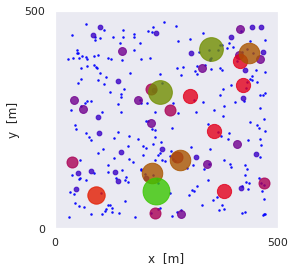

In [36]:
fig= plot_scatter_time(N[1:2,:1,:,:,:],9,dx=dx,dy=dy,figsize=(4,4),color=color_rgb,alpha=np.ones(10)*0.8,sizes=siz**2/1000,buffer=0.05)
plt.title('')

In [20]:
fig.savefig('single_grid_scatter.pdf',bbox_inches='tight')

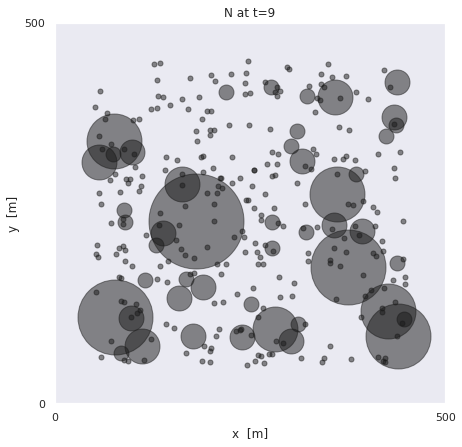

In [45]:
fig= plot_scatter_time(N[:1,:1,:,:,:],9,dx=dx,dy=dy,figsize=(7,7),color=['k','k','k','k','k','k','k','k','k','k'],alpha=np.ones(10)*0.5,sizes=siz**2/100)

# Plotting size distribution


In [5]:
siz

array([ 50., 150., 250., 350., 450., 550., 650., 750., 850., 950.])

In [6]:
B_0*60*dx*dy

array([256.        ,  28.44444444,  10.24      ,   5.2244898 ,
         3.16049383,   2.11570248,   1.5147929 ,   1.13777778,
         0.88581315,   0.70914127])

In [7]:

N_ref_10 = L_ref/20*10**(-2)
N_ref_10000 = L_ref/20*10000**(-2)


#--- birth and lifetime constants --------
B_ref_10      = N_ref_10/L_ref   #average nr of object births / m2 / s
B_ref_10000    = N_ref_10000/L_ref   #average nr of object births / m2 / s
#rescaling to get exactly 256 for x - 50
B_ref_10   =B_ref_10   *256/300 
B_ref_10000 =B_ref_10000 *256/300 

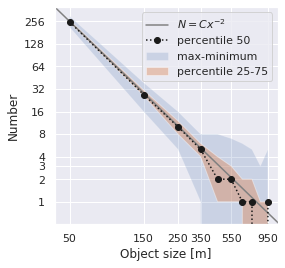

In [20]:
#Firt plot a simple N plot for N t=1 x=0 y=0

#--- percentile plot of the CSD ---
fig,ax = plt.subplots(1,1,figsize=(4,4))


sd_N_lin_p01    = np.percentile( N[:,0,:,0,0],  1., axis=0 ,interpolation='nearest')    #25% percentile
sd_N_lin_p25    = np.percentile( N[:,0,:,0,0], 25., axis=0 ,interpolation='nearest')    #25% percentile
sd_N_lin_p50    = np.percentile( N[:,0,:,0,0], 50., axis=0 ,interpolation='nearest')    #50% percentile
sd_N_lin_p75    = np.percentile( N[:,0,:,0,0], 75., axis=0 ,interpolation='nearest')    #75% percentile
sd_N_lin_p99    = np.percentile( N[:,0,:,0,0], 99., axis=0 ,interpolation='nearest')    #75% percentile
sd_N_lin_max    = np.max( N[:,0,:,0,0], axis=0)    #75% percentile
sd_N_lin_min    = np.min( N[:,0,:,0,0], axis=0)    #75% percentile



plt.plot        (np.array([10,10000]), np.array([B_ref_10,B_ref_10000])*dx*dy*60, '-', color='gray'        ,label=r'$N=Cx^{-2}$')
#plt.fill_between(siz, sd_N_lin_p01, sd_N_lin_p99, alpha=0.2,label='percentile 01-99')
plt.fill_between(siz, sd_N_lin_min, sd_N_lin_max, alpha=0.2,label='max-minimum')
plt.fill_between(siz, sd_N_lin_p25, sd_N_lin_p75, alpha=0.4,label='percentile 25-75')
plt.plot        (siz, sd_N_lin_p50, 'o:', color='k'        ,label='percentile 50')


plt.legend()




plt.xscale('log')
plt.yscale('log')

plt.xlabel('Object size [m]')
plt.ylabel('Number')

plt.ylim([.5,400.])
plt.xlim([40,1100.])

ax.set_xticks(siz[[0,1,2,3,5,9]])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_yticks([int(1),2,3,4,8,16,2**5,4**3,2**7,4**4])

ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    
#plt.show()                         # Show the figure

#fig.savefig('N_thermals_movie_CSD.png',bbox_inches = 'tight')
#fig.savefig('N_thermals_movie_CSD.pdf',bbox_inches = 'tight')

#plt.close(fig)



In [21]:
fig.savefig('size_distribution_sampling_0421.pdf',bbox_inches='tight')

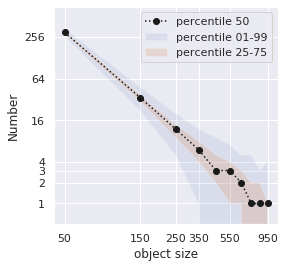

In [91]:
#Firt plot a simple N plot for N t=1 x=0 y=0

#--- percentile plot of the CSD ---
fig,ax = plt.subplots(1,1,figsize=(4,4))


sd_N_lin_p01    = np.percentile( N[:,0,:,0,0],  1., axis=0 ,interpolation='nearest')    #25% percentile
sd_N_lin_p25    = np.percentile( N[:,0,:,0,0], 25., axis=0 ,interpolation='nearest')    #25% percentile
sd_N_lin_p50    = np.percentile( N[:,0,:,0,0], 50., axis=0 ,interpolation='nearest')    #50% percentile
sd_N_lin_p75    = np.percentile( N[:,0,:,0,0], 75., axis=0 ,interpolation='nearest')    #75% percentile
sd_N_lin_p99    = np.percentile( N[:,0,:,0,0], 99., axis=0 ,interpolation='nearest')    #75% percentile



plt.fill_between(siz, sd_N_lin_p01, sd_N_lin_p99, alpha=0.1,label='percentile 01-99')
plt.fill_between(siz, sd_N_lin_p25, sd_N_lin_p75, alpha=0.2,label='percentile 25-75')
plt.plot        (siz, sd_N_lin_p50, 'o:', color='k'        ,label='percentile 50')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('object size')
plt.ylabel('Number')

plt.ylim([.5,700.])

ax.set_xticks(siz[[0,1,2,3,5,9]])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_yticks([1,2,3,4,16,4**3,4**4])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.legend()
    
#plt.show()                         # Show the figure

#fig.savefig('N_thermals_movie_CSD.png',bbox_inches = 'tight')
#fig.savefig('N_thermals_movie_CSD.pdf',bbox_inches = 'tight')

#plt.close(fig)



In [93]:
fig.savefig('size_distribution_sampling.pdf',bbox_inches='tight')